In [2]:
library(Seurat)
library(SeuratDisk)
library(NMF)
library(ggalluvial)
library(ComplexHeatmap)
library(CellChat)
library(patchwork)
library(graphics)
library(Matrix)
options(stringsAsFactors = FALSE)
library(NeuronChat)

library(circlize)
library(colorspace)
options(repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 300)

library(pracma)
library(glue)
################
## Parameters ##
################
# NMF
#versions that will be made for each combination (resulting in that many figures being made)
versions = seq(from = 1, to = 20, by = 1) 
# NMF methods to be used, can be "brunet" or "lee"...
methods = list("brunet")
# NMF seeding methods to be used, can be "random" or "nndsvd"...
seeds = list("random")
# NMF number of runs to be used, can be 200, 500, 1000, 2000, 5000, 10000...
nrums = list(200)

inhibitory_celltypes <- c("Chandelier", "Lamp5", "Lamp5 Lhx6", "Pax6", "Pvalb", "Sst", "Sst Chodl", "Vip", "Sncg")
inhibitory_celltypes <- inhibitory_celltypes[order(inhibitory_celltypes)]
# excitatory_celltypes <- c("L2/3 IT", "L4 IT", "L5", "L5 ET", "L5/6 ET", "L6 CT", "L6 IT", "L6 IT Car3","L5 IT","L5/6 NP","L6b")
excitatory_celltypes <- c("L2/3 IT CTX", "L4 IT", "L5", "L5 ET", "L5/6 ET", "L6 CT", "L6 IT", "L6 IT Car3","L5 IT","L5/6 NP","L6b")
excitatory_celltypes <- excitatory_celltypes[order(excitatory_celltypes)]
support_celltypes <- c("Astro","Endo","Micro/PVM", "Oligo", "OPC", "VLMC")

# AUD
inhibitory_celltypes = c('inhib-1', 'inhib-2', 'inhib-3', 'inhib-4', 'inhib-5', 'inhib-6')
excitatory_celltypes = c('excit-1', 'excit-2', 'excit-3')
support_celltypes = c('astro', 'endo', 'MG', 'oligo-1', 'oligo-2', 'opc', 'micro', 'mural', 'macro')

inhibitory_celltypes <- inhibitory_celltypes[order(inhibitory_celltypes)]
excitatory_celltypes <- excitatory_celltypes[order(excitatory_celltypes)]
support_celltypes <- support_celltypes[order(support_celltypes)]
#################

Loading required package: pkgmaker

Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 255/256

  To enable shared memory capabilities, try: install.extras('
NMF
')


Attaching package: ‘NMF’


The following objects are masked from ‘package:igraph’:

    algorithm, compare



Attaching package: ‘pracma’


The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu




In [8]:
library(NeuronChat)
library(CellChat)
library(ggalluvial)
library(glue)
library(Seurat)
library(SeuratDisk)
library(ComplexHeatmap)
library(circlize)

# Cheyu's merged river function

In [19]:
outgoing_ligand_order <- c()

my_merged_river <- function(object,pattern, disease, inhibitory_celltypes, excitatory_celltypes, support_celltypes){

    if (pattern == "outgoing") {
      main.title = "Outgoing communication patterns of secreting cells"
      # The color palette is defined in the function ggPalette
      # color.use just needs three colors you can define them in a list with hex codes if you want 
      color.use <- ggPalette(3*2)[seq(1,3*2, by = 2)]
      
    } else if (pattern == "incoming") {
      main.title = "Incoming communication patterns of target cells"
      # The color palette is defined in the function ggPalette
      # color.use just needs three colors you can define them in a list with hex codes if you want 
      color.use <- ggPalette(3*2)[seq(2,3*2, by = 2)]
    }

    slot.name = "net"
    # res.pattern <- methods::slot(object, slot.name)$pattern[[pattern]]
    res.pattern <- methods::slot(object, 'net_analysis')$pattern[[pattern]]

    data1 = res.pattern$pattern$cell
    data2 = res.pattern$pattern$signaling

    sorted_group <- data2[order(data2$Signaling, -data2$Contribution),]
    data2 <- sorted_group[!duplicated(sorted_group$Signaling),]

    sorted_group <- data1[order(data1$CellGroup, -data1$Contribution),]
    data1 <- sorted_group[!duplicated(sorted_group$CellGroup),]

    plot.data <- merge(data1,data2,by="Pattern")

    plot.data$Signaling <- as.character(plot.data$Signaling)
    print(unique(plot.data$Signaling))
    plot.data <- plot.data[order(plot.data$Pattern, plot.data$Signaling),]

    # -- this is code for pulling out custom ligands
    # ligand_in_order = ligand_in_order[!ligand_in_order %in% c("FGF", "NRG", "PSAP")]
    # ligand_in_order = c(ligand_in_order, "FGF", "NRG", "PSAP")
    # plot.data$Signaling <- factor(plot.data$Signaling, levels = ligand_in_order)

    # order ligands by pattern
    if(pattern == "outgoing"){
      if(length(outgoing_ligand_order) > 0){
          plot.data$Signaling <- factor(plot.data$Signaling, levels = outgoing_ligand_order) 
      } 
      else {
        if(disease == "control"){
            outgoing_ligand_order <<- c()
            for (pattern in unique(plot.data$Pattern)){
              outgoing_ligand_order <<- c(outgoing_ligand_order, unique(plot.data$Signaling[plot.data$Pattern == pattern]))
            }
            plot.data$Signaling <- factor(plot.data$Signaling, levels = outgoing_ligand_order) 
        }
      }
    }
    else if(pattern == "incoming"){
      if(length(incoming_ligand_order) > 0){
          plot.data$Signaling <- factor(plot.data$Signaling, levels = incoming_ligand_order) 
      } 
      else {
        if(disease == "control"){
            incoming_ligand_order <<- c()
            for (pattern in unique(plot.data$Pattern)){
              incoming_ligand_order <<- c(incoming_ligand_order, unique(plot.data$Signaling[plot.data$Pattern == pattern]))
            }
            plot.data$Signaling <- factor(plot.data$Signaling, levels = incoming_ligand_order) 
        }
      }
    }

    #order cell types by cell type groups
    # inhibitory_celltypes <- c("Chandelier", "Lamp5", "Lamp5 Lhx6", "Pax6", "Pvalb", "Sst", "Sst Chodl", "Vip", "Sncg")
    inhibitory_celltypes <- inhibitory_celltypes[order(inhibitory_celltypes)]
    # excitatory_celltypes <- c("L2/3 IT", "L4 IT", "L5", "L5 ET", "L5/6 ET", "L6 CT", "L6 IT", "L6 IT Car3","L5 IT","L5/6 NP","L6b")
    excitatory_celltypes <- excitatory_celltypes[order(excitatory_celltypes)]
    # support_celltypes <- c("Astro","Endo","Micro/PVM", "Oligo", "OPC", "VLMC")

    celltypesOrder <- c(support_celltypes, inhibitory_celltypes, excitatory_celltypes)
    plot.data$CellGroup <- factor(plot.data$CellGroup, levels = celltypesOrder)

    #scale by cellgroup
    goal_sum <- 1
    for(celltype in unique(plot.data$CellGroup)){
        goal_sum <- pracma::Lcm(
            goal_sum,
            sum(plot.data$CellGroup == celltype)
        )
    }

    print(goal_sum)

    for(celltype in unique(plot.data$CellGroup)){
        index_to_copy <- which(match(plot.data$CellGroup, celltype) == 1)
        while(sum(plot.data$CellGroup == celltype) != goal_sum){
            for (index in index_to_copy){
                    plot.data <- rbind(plot.data, plot.data[rep(index, 1), ])

            }
        }
    }

    # Some signaling is NA, this will cause angles to be different length.
    plot.data <- subset(plot.data, !is.na(plot.data$Signaling))

    #make Pattern text Vertical
    angles <- rep(0, length(unique(plot.data$Pattern)) + length(unique(plot.data$CellGroup)) + length(unique(plot.data$Signaling)))
    for (i in seq(length(unique(plot.data$CellGroup))+1,length(unique(plot.data$CellGroup))+3)){
        angles[i] <- 90
    }

    #make our plot
    gg <- ggplot(plot.data,
        aes(axis1 = CellGroup, axis2 = Pattern, axis3 = Signaling)) +
    geom_flow(width = 1/3, aes.flow = "forward", aes(fill = Pattern)) + 
    scale_x_discrete(limits = c("Cell groups", "Pattern", "Signaling" )) +
    geom_stratum(alpha = 0.8, aes(fill = Pattern),width = 1/3, size=0.1) + 
    scale_fill_manual(values = color.use) +
    geom_text(angle=angles, size = 4, stat = "stratum", aes(label = after_stat(stratum))) +
    theme_bw()+
        theme(legend.position = "none",
            axis.title = element_blank(),
            axis.text.y= element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor  = element_blank(),
            panel.border = element_blank(),
            axis.ticks = element_blank(),axis.text=element_text(size= 10)) + 
            theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle(main.title)
    return(gg)
}

In [13]:
neuronchat_obj = readRDS('RNA_FINAL-strict_0-method_trimean-fdr_0.05-permute_100-PTSD_neuronchat.rds')

In [22]:
inhibitory_celltypes <- c('Inh KCNG1', 'Inh LAMP5', 'Inh PVALB', 'Inh SST', 'Inh VIP')
excitatory_celltypes <- c('Exc CUX2', 'Exc FEZF2', 'Exc OPRK1', 'Exc RORB')
support_celltypes <- c('Astro', 'Endo', 'MG', 'Oligo', 'OPC')
plot = my_merged_river(neuronchat_obj, "outgoing", 'PTSD', inhibitory_celltypes, excitatory_celltypes, support_celltypes)

 [1] "ADCYAP1_VIPR1"     "CO_GUCY1A2"        "ADCYAP1_VIPR2"    
 [4] "ADCYAP1_ADCYAP1R1" "CO_GUCY1B1"        "Glu_GRIK1"        
 [7] "Glu_GRIK2"         "Glu_GRIA3"         "Glu_GRIA4"        
[10] "CO_GUCY1A1"        "Glu_GRIN1"         "Glu_GRIK3"        
[13] "Glu_GRIK4"         "Glu_GRM4"          "Glu_GRIA1"        
[16] "Glu_GRIA2"         "Glu_GRM1"          "Glu_GRIK5"        
[19] "NRXN2_NLGN3"       "Glu_GRM5"          "Glu_GRM7"         
[22] "Glu_GRM3"          "NRXN3_NLGN3"       "NRXN3_NLGN4X"     
[25] "Glu_GRIN2A"        "Glu_GRM8"          "Glu_GRIN2C"       
[28] "Glu_GRIN2D"        "Glu_GRIN3A"        "NRXN2_NLGN1"      
[31] "NRXN2_NLGN2"       "NRXN2_NLGN4X"      "NRXN3_NLGN1"      
[34] "NRXN3_NLGN2"       "Glu_GRIN2B"        "CCK_CCKBR"        
[37] "CRH_CRHR1"         "GABA_GABBR1"       "GABA_GABBR2"      
[40] "GABA_GABRA2"       "GABA_GABRA3"       "GABA_GABRA4"      
[43] "GABA_GABRA5"       "GABA_GABRA6"       "GABA_GABRB1"      
[46] "GABA_GABRB2"       

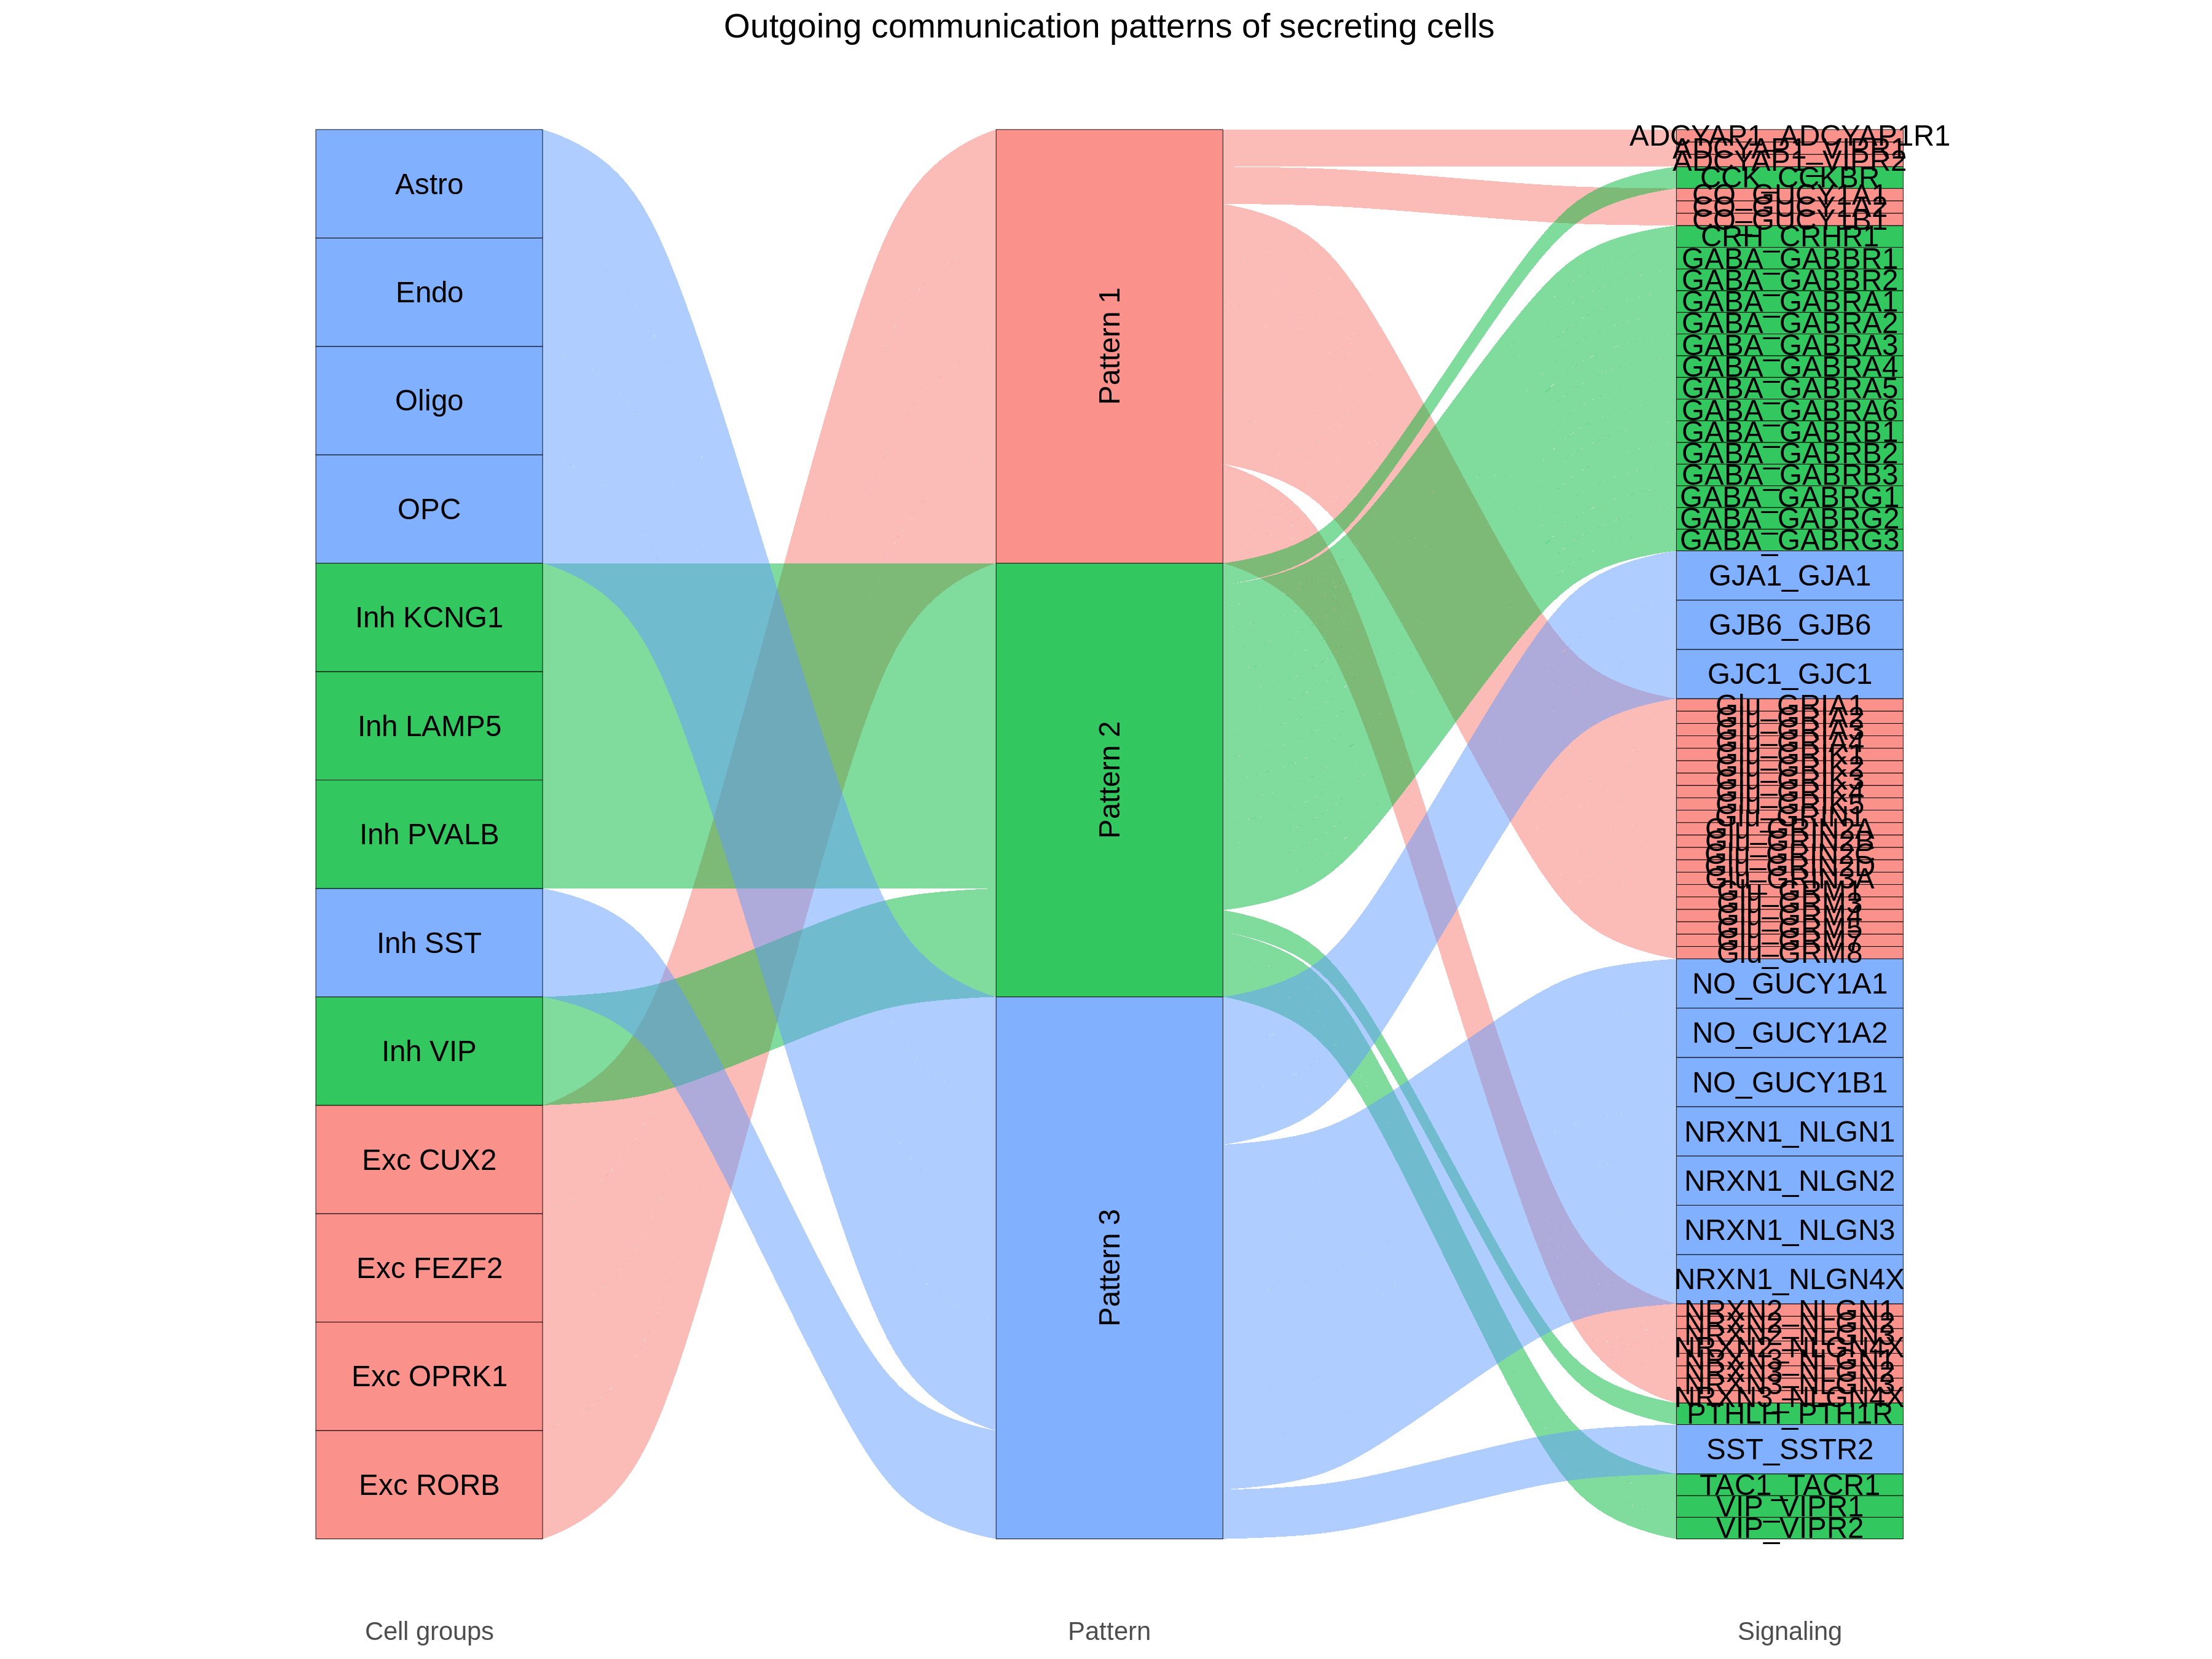

In [23]:
plot